<a href="https://colab.research.google.com/github/urieliram/tc_uc/blob/main/Figures_TC_UC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
cm = 1/2.54

# GRÁFICOS DE CONVERGENCIA milp, milp2, hard3, harjk lbc, ks, 


## Lectura de archivos log

In [2]:
## Lectura de datos
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Log1.zip to Log1.zip
User uploaded file "Log1.zip" with length 10227 bytes


In [ ]:
# !pip install unrar
# !unrar x "/content/Logs1.rar"

In [3]:
!unzip "Log1.zip" -d "/content"

Archive:  Log1.zip
  inflating: /content/Logs.txt       
  inflating: /content/Log_071.log    
  inflating: /content/Log_072.log    
  inflating: /content/Log_073.log    


In [4]:
def validateFiles():
  list=[]
  f = open("/content/Logs.txt","r")
  validFiles = [i.replace("\n","") for i in f]
  #print(validFiles)
  f.close()
  onlyfiles = [f.split(".")[0] for f in listdir("/content") if isfile(join("/content", f))]
  for i in validFiles:
    list.append(i)
    if i not in onlyfiles:
      return False
  return True, list
list=[]
if validateFiles() is False:
   print("!!! Faltan archivos")   
   temp, list = validateFiles()
   print(list)
else:
   temp, list = validateFiles()
   print("Archivos completos")
   

Archivos completos


## Extrae información de los logs

In [5]:
class Extract:
  def __init__(self,log):
    self.log = log
 
  def getFilelog(self,f):
    with open(f, 'r') as file:
      data = file.read().replace('\n', '')
    tmp = []
    for i in re.findall(r"\w*"+self.log+"\s*\'*[a-zA-z.+]*\'",data):
      print(i)
      tmp.append(i.replace("'","").split(" ")[1])
    return tmp

  def extract(self):
    fn= "/content/"+self.log+".log"
    variables = {}
    variables["logFile"] = self.log.replace("Log","uc")
    f = open(fn, "r")  
    line = 1 
    for i in f:
      if("lbc1 results" in i):
        variables["lbc1_a"]  = line
      if("lbc1 end" in i):
        variables["lbc1_b"]  = line
      if("lbc2 results" in i):
        variables["lbc2_a"]  = line
      if("lbc2 end" in i):
        variables["lbc2_b"]  = line
      if("lbc3 results" in i):
        variables["lbc3_a"]  = line
      if("lbc3 end" in i):
        variables["lbc3_b"]  = line
      if("lbc4 results" in i):
        variables["lbc4_a"]  = line
      if("lbc4 end" in i):
        variables["lbc4_b"]  = line
      if("KS results" in i):
        variables["KS_a"]    = line
      if("KS end" in i):
        variables["KS_b"]    = line
      if("z_milp=" in i):
        variables["z_milp"]  = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_milp2=" in i):
        variables["z_milp2"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_harjk=" in i):
        variables["z_harjk"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_hard3=" in i):
        variables["z_hard3"] = float(i.replace(" ","").replace("\n","").split("=")[1])        
      if("t_milp=" in i):
        variables["t_milp"]  = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_milp2=" in i):
        variables["t_milp2"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_harjk=" in i):
        variables["t_harjk"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_hard3=" in i):
        variables["t_hard3"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_lp=" in i):
        variables["z_lp"]   = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_lp=" in i):
        variables["t_lp"]   = float(i.replace(" ","").replace("\n","").split("=")[1])
      line = line + 1
    return variables

In [14]:
cat_z = ['z_milp','z_milp2','z_harjk','z_hard3']
cat_t = ['t_milp','t_milp2','t_harjk','t_hard3']
list2 = []
for item in list:
    try:
      e         = Extract(item)
      variables = e.extract()
      print(variables['t_milp'],variables['z_milp'])
      list2.append(variables)
    except Exception as err:
      print("Fail in ", item+".log"+ " file")
      print(str(err))

7267.9 1e+75
7281.9 1e+75
Fail in  Log_073.log file
't_milp'


In [12]:
print(list2)

[{'logFile': 'uc_071', 't_milp': 7267.9, 'z_milp': 1e+75, 't_lp': 133.0, 'z_lp': 102725895.3, 't_hard3': 1273.7, 'z_hard3': 102805929.9, 't_harjk': 1274.4, 'z_harjk': 102805159.2, 'lbc1_a': 86, 'lbc1_b': 94, 'lbc2_a': 150, 'lbc2_b': 158, 'lbc3_a': 212, 'lbc3_b': 220, 'lbc4_a': 283, 'lbc4_b': 291, 'KS_a': 541, 'KS_b': 584, 't_milp2': 7520.8, 'z_milp2': 102805929.9}, {'logFile': 'uc_072', 't_milp': 7281.9, 'z_milp': 1e+75, 't_lp': 162.5, 'z_lp': 111938139.1, 't_hard3': 1290.0, 'z_hard3': 111990388.6, 't_harjk': 1292.5, 'z_harjk': 112035397.0, 'lbc1_a': 85, 'lbc1_b': 93, 'lbc2_a': 147, 'lbc2_b': 155, 'lbc3_a': 208, 'lbc3_b': 216, 'lbc4_a': 268, 'lbc4_b': 275, 't_milp2': 7295.5, 'z_milp2': 111990341.4}, {'logFile': 'uc_073', 't_hard3': 1287.5, 'z_hard3': 109840106.9, 't_harjk': 1284.8, 'z_harjk': 1e+75, 'lbc1_a': 87, 'lbc1_b': 95, 'lbc2_a': 151, 'lbc2_b': 159, 'lbc3_a': 212, 'lbc3_b': 220, 'lbc4_a': 273, 'lbc4_b': 280, 'KS_a': 435, 'KS_b': 461}]


## Despliega gráficas

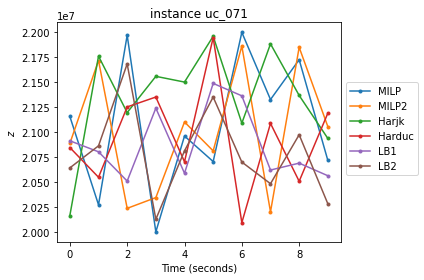

In [49]:
title = 'instance uc_071'
plt.figure()
models = ['MILP','MILP2','Harjk','Harduc','LB1','LB2','LB3','LB4','KS']
for i in range(6):
  # define data values
  x = np.arange(10)                                                # X-axis points
  y = np.random.randint(low = 20000000, high = 22000000, size=10)  # Y-axis points
  plt.plot(x, y, '.-', label = models[i])

plt.xlabel("Time (seconds)")
plt.ylabel("$z$")
plt.title(title)
plt.legend(bbox_to_anchor=(1, 0.75))
plt.tight_layout()
plt.savefig('test.pdf')
plt.show()

# GRAFICOS DE BOXPLOT


## Ejemplo boxplot

In [32]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://drive.google.com/file/d/1ySF5y3FdEZrEAu1jZ_P1PdBJSk64TQvt/view?usp=share_link'
df   = pd.read_csv(path+URL.split('/')[-2],header=0)
                #  dtype={'SERIE11':float,'SERIE12':float,'SERIE13':float,'SERIE14':float,'SERIE15':float,'SERIE16':float,'SERIE17':float})
#names=['MILP','FP','Harjk','Hard','LB1','LB2','LB3','KS']
#dtype={'MEM1':float,'MEM2':float,'MEM3':float,'MEM4':float}

##      z_milp	z_feas	z_harjk	 z_hard3	z_lbc1	z_lbc2	z_lbc3	z_ks    (09-16)
##    	t_milp	t_feas	t_harjk  t_hard3	t_lbc1	t_lbc2	t_lbc3	t_ks    (18-26)
##      g_milp	g_feas	g_harjk	 g_hard3	g_lbc1	g_lbc2	g_lbc3	g_ks    (28-35)
df.dropna(inplace=True)

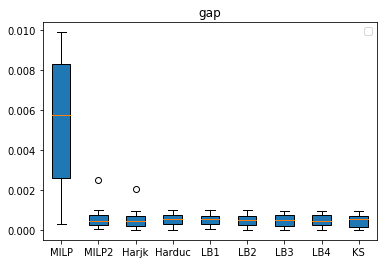

In [46]:
##Imprimir GAP
data1  = df.g_milp.to_numpy()
data2  = df.g_milp2.to_numpy()
data3  = df.g_harjk.to_numpy()
data4  = df.g_hard3.to_numpy()
data5  = df.g_lbc1.to_numpy()
data6  = df.g_lbc2.to_numpy()
data7  = df.g_lbc3.to_numpy()
data8  = df.g_lbc4.to_numpy()
data9  = df.g_ks.to_numpy()
labels = ['MILP','MILP2','Harjk','Harduc','LB1','LB2','LB3','LB4','KS']
x=[data1,data2,data3,data4,data5,data6,data7,data8,data9]
fig,ax = plt.subplots()
ax.set_title('gap')
bp = ax.boxplot(x,           
positions=[1,2,3,4,5,6,7,8,9],      # where to put these arrays
labels = labels, patch_artist=True)  # allow filling the box with colors
# ax.legend()
namefile = 'fig:boxplotgap'+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

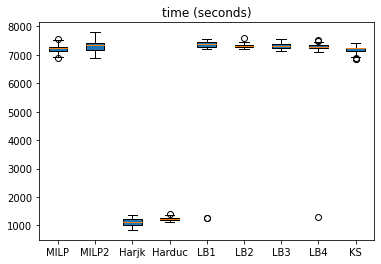

In [47]:
##Imprimir TIME
data1  = df.t_milp.to_numpy()
data2  = df.t_milp2.to_numpy()
data3  = df.t_harjk.to_numpy()
data4  = df.t_hard3.to_numpy()
data5  = df.t_lbc1.to_numpy()
data6  = df.t_lbc2.to_numpy()
data7  = df.t_lbc3.to_numpy()
data8  = df.t_lbc4.to_numpy()
data9  = df.t_ks.to_numpy()
labels = ['MILP','MILP2','Harjk','Harduc','LB1','LB2','LB3','LB4','KS']
x=[data1,data2,data3,data4,data5,data6,data7,data8,data9]
fig,ax = plt.subplots()
ax.set_title('time (seconds)')
bp = ax.boxplot(x,           
positions=[1,2,3,4,5,6,7,8,9],      # where to put these arrays
labels = labels, patch_artist=True)  # allow filling the box with colors
# ax.legend()
namefile = 'fig:boxplottime'+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

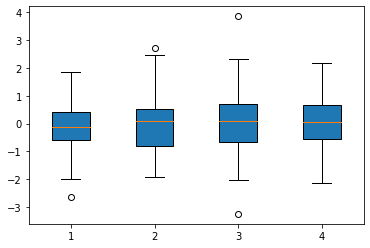

In [48]:

#https://towardsdatascience.com/making-publication-quality-figures-in-python-part-iii-box-plot-bar-plot-scatter-plot-407fa457449
# prepare some data
np.random.seed(42)
data1 = np.random.randn(100)
data2 = np.random.randn(100)
data3 = np.random.randn(100)
data4 = np.random.randn(100)

fig,ax = plt.subplots()
bp = ax.boxplot(x=[data1,data2,data3,data4],  # sequence of arrays
positions=[1,2,3,4],   # where to put these arrays
patch_artist=True)  # allow filling the box with colors
# ax.legend()
namefile = 'boxplot_'+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()